In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:

path='/Volumes/LB_Reiterlab_2/10X_042519/Tdsort_notrans/'
results_file = '/Volumes/LB_Reiterlab_2/10X_042519/Tdsort_notrans/Td_scanpy_v8_rerun.h5ad'  # the file that will store the analysis results

sc.settings.set_figure_params(dpi=80)

adata = sc.read_10x_mtx(path + 'filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

adata

AnnData object with n_obs × n_vars = 9097 × 31053 
    var: 'gene_ids', 'feature_types'

In [3]:

adata = sc.read_10x_mtx(
    path + 'filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

adata

AnnData object with n_obs × n_vars = 9097 × 31053 
    var: 'gene_ids', 'feature_types'

In [4]:

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


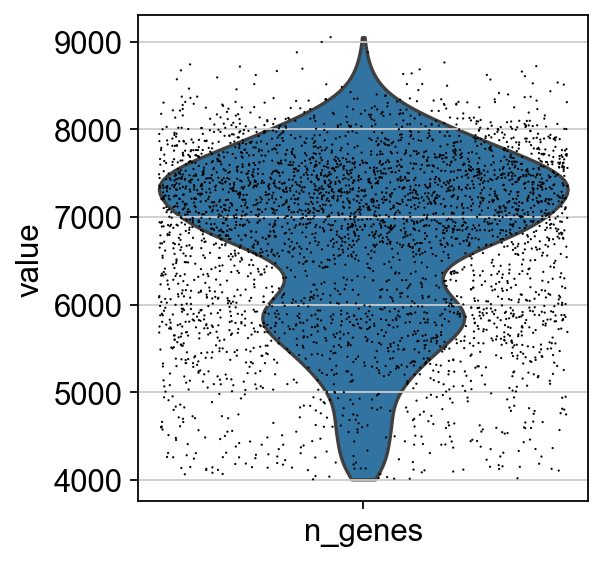

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


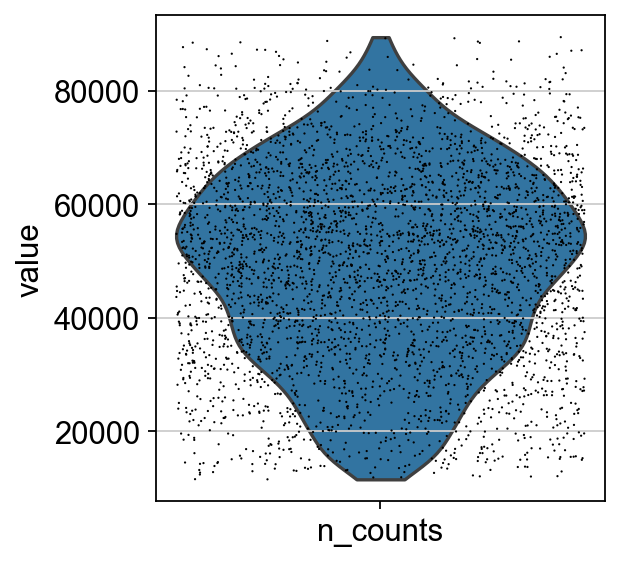

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


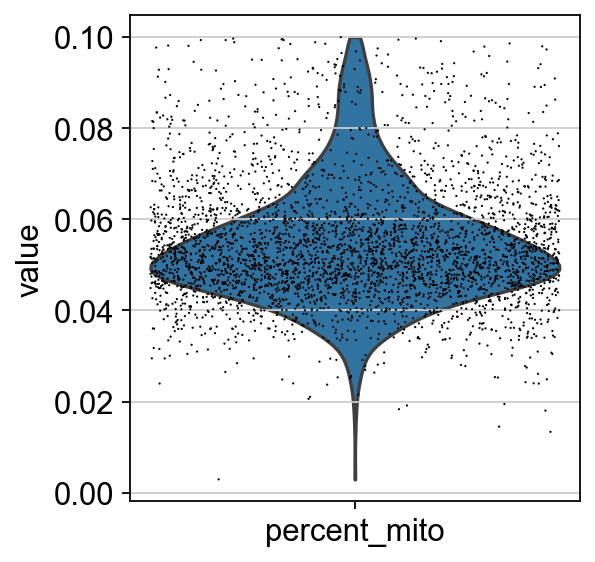

In [6]:
adata = adata[adata.obs['n_genes'] > 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.10, :]
adata = adata[adata.obs['n_counts'] < 89594.99, :]
sc.pl.violin(adata, ['n_genes'],jitter=0.4)
sc.pl.violin(adata, ['n_counts'],jitter=0.4)
sc.pl.violin(adata, ['percent_mito'],jitter=0.4)

In [7]:
####### doublets ##########

import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
counts_matrix = adata.X
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))

Counts matrix shape: 3778 rows, 18941 columns


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 11.6%
Overall doublet rate:
	Expected   = 3.5%
	Estimated  = 2.3%
Elapsed time: 9.3 seconds
Detected doublet rate = 3.9%
Estimated detectable doublet fraction = 49.5%
Overall doublet rate:
	Expected   = 3.5%
	Estimated  = 8.0%


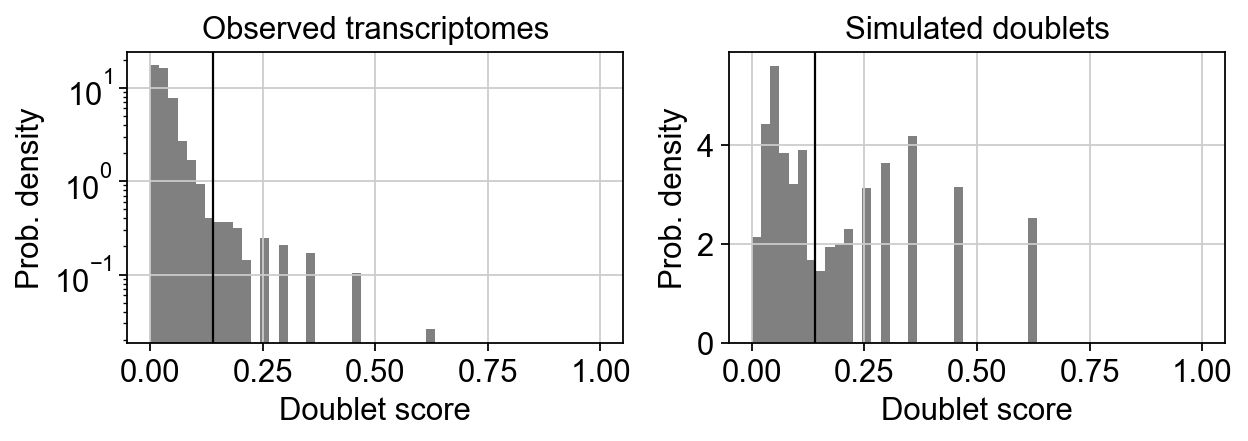

In [9]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=.035)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

predicted_doublets = scrub.call_doublets(threshold=0.14)

scrub.plot_histogram();


Running UMAP...


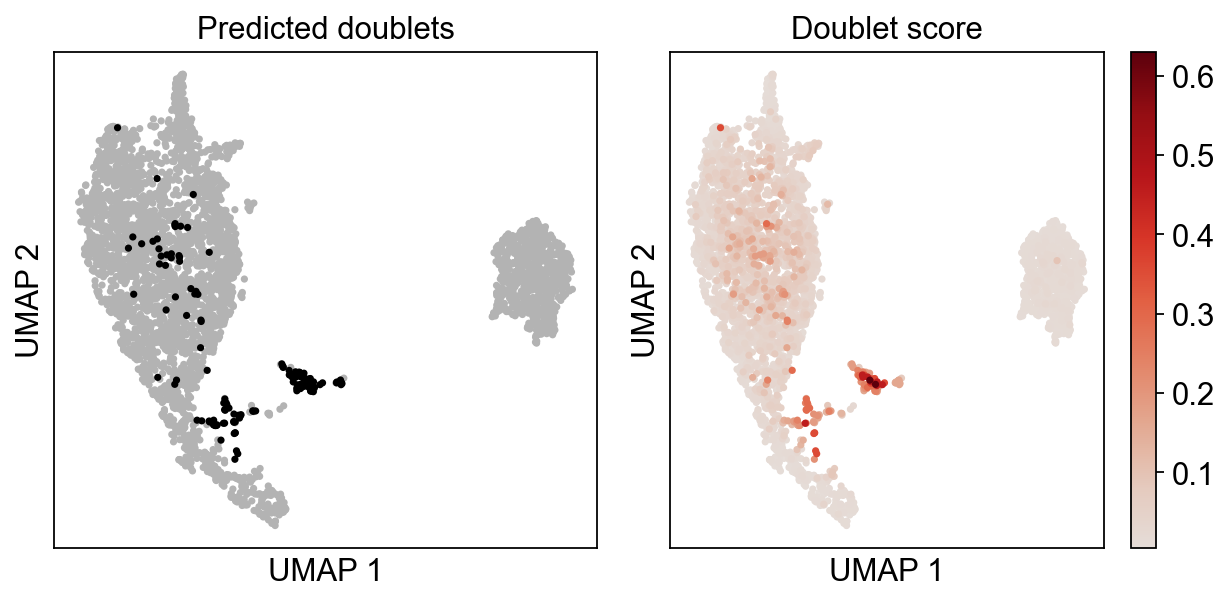

In [10]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);

In [11]:
cellbarc = adata.obs.index

df=pd.DataFrame({
        'cell_barcodes':cellbarc,
        'doublet_score':scrub.doublet_scores_obs_,
        'predicted_doublet':scrub.predicted_doublets_
        })
df.to_csv(path+'v8/Tdsort_scrublet_3.5perc_thresh0.14_output_table_rerun.csv',index=False)